# LoRaWAN Network Data Analyzer

Dieses Notebook analysiert LoRaWAN-Netzwerkparameter mit umfassendem Fokus auf die Spreading Factor (SF) Analyse.

## Analyseschwerpunkte:
1. **Spreading Factor Übersicht**
   - Verteilung und Häufigkeit der SF
   - Performance-Auswirkungen auf Signalqualität

2. **Detaillierte SF-Analyse**
   - SNR und RSSI pro SF
   - Histogramme und Heatmaps zur Empfangsqualität

3. **Netzwerkparameter und Datentransfer**
   - Frequenz, Bandbreite
   - Frame Counter und Gateway-Statistiken

4. **Zeitbezogene Analysen**
   - Veränderungen von SF über die Zeit
   - Session-Dauer und Nachrichtenintervalle

In [96]:
# Bibliotheken Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from datetime import datetime
from glob import glob
import warnings

# Style und Warnungen
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Bibliotheken erfolgreich importiert!")
print("📊 Plotting Bibliotheken konfiguriert!")

✅ Bibliotheken erfolgreich importiert!
📊 Plotting Bibliotheken konfiguriert!


In [97]:

print("✅ LoRaWAN-Funktionen definiert!")

✅ LoRaWAN-Funktionen definiert!


In [98]:
# Zeige verfügbare Dateien
available_files = get_available_files()
display_file_info(available_files)

📡 Verfügbare LoRaWAN Session Dateien:
 1. lorawan_session_20250707_221949_TL2_Lang.csv
     📈 561 Messungen, 182.3 KB
     📅 2025-08-03 19:37:09

 2. lorawan_session_20250707_235158_TL2_Schacht_zu.csv
     📈 31 Messungen, 10.4 KB
     📅 2025-08-03 19:38:46

 3. lorawan_session_20250708_001649_leitung nord offen auf auto.csv
     📈 77 Messungen, 24.9 KB
     📅 2025-08-03 19:39:29

 4. lorawan_session_20250708_004441_LeitungNordzu.csv
     📈 13 Messungen, 4.5 KB
     📅 2025-08-03 19:40:50

 5. zusammengefuegt.csv
     📈 772 Messungen, 250.0 KB
     📅 2025-08-03 19:44:14



In [99]:
# DATEIAUSWAHL - Ändern Sie hier die Zahl entsprechend der gewünschten Datei
selected_file_index = 5  # Empfohlen: 19 (größte Datei mit 623 Messungen)

if 1 <= selected_file_index <= len(available_files):
    selected_file = available_files[selected_file_index - 1]
    print(f"🎯 Ausgewählte Datei: {selected_file}")
    
    # Lade die LoRaWAN-Daten
    df = load_and_process_lorawan_data(selected_file)
    print(f"✅ Daten erfolgreich geladen: {len(df)} LoRaWAN-Nachrichten")
    
else:
    print(f"❌ Ungültige Auswahl! Bitte wählen Sie eine Zahl zwischen 1 und {len(available_files)}")

🎯 Ausgewählte Datei: zusammengefuegt.csv
✅ Daten erfolgreich geladen: 772 LoRaWAN-Nachrichten


In [100]:
# Umfassender Datenüberblick
print("📊 UMFASSENDER DATENÜBERBLICK")
print("=" * 60)
print(f"📄 Dateiname: {selected_file}")
print(f"📊 Gesamtanzahl der Datensätze: {len(df)}")

if len(df) > 0:
    time_min = df['timestamp'].min()
    time_max = df['timestamp'].max()
    print(f"⏰ Zeitbereich: {time_min} bis {time_max}")
    print(f"⏱️  Dauer: {time_max - time_min}")
    
    unique_devices = df['device_eui'].nunique()
    unique_sessions = df['session_id'].nunique()
    unique_gateways = df['gateway_id'].nunique()
    print(f"🏷️  Eindeutige Geräte: {unique_devices}")
    print(f"🏷️  Eindeutige Sessions: {unique_sessions}")
    print(f"🏷️  Eindeutige Gateways: {unique_gateways}")
    
    print("\n📋 Verfügbare Spalten:")
    print(f"   {', '.join(df.columns)}")
    
    # Numerische Statistiken
    print("\n📊 Statistische Übersicht (numerische Spalten):")
    numeric_cols = ['rssi_dbm', 'snr_db', 'spreading_factor', 'fcnt']
    existing_numeric = [col for col in numeric_cols if col in df.columns]
    if existing_numeric:
        stats_df = df[existing_numeric].describe()
        print(stats_df.round(2))

📊 UMFASSENDER DATENÜBERBLICK
📄 Dateiname: zusammengefuegt.csv
📊 Gesamtanzahl der Datensätze: 772
⏰ Zeitbereich: 2025-07-07 22:20:40 bis 2025-07-08 00:50:37
⏱️  Dauer: 0 days 02:29:57
🏷️  Eindeutige Geräte: 1
🏷️  Eindeutige Sessions: 4
🏷️  Eindeutige Gateways: 1

📋 Verfügbare Spalten:
   timestamp, session_id, application_id, device_eui, event_type, fcnt, fport, raw_data_hex, raw_data_ascii, decoded_payload, gateway_id, rssi_dbm, snr_db, spreading_factor, bandwidth, frequency, gateway_lat, gateway_lon, gateway_alt, device_lat, device_lon, device_alt, battery_level, margin_db, acknowledged, gps_source, gps_format, sf_numeric

📊 Statistische Übersicht (numerische Spalten):
       rssi_dbm  snr_db    fcnt
count    772.00  743.00  772.00
mean     -83.79    0.56  308.98
std       12.84    5.21  208.40
min      -98.00  -16.50    0.00
25%      -89.00   -2.20  103.75
50%      -88.00   -0.50  296.50
75%      -87.00    2.50  490.25
max       -9.00   16.20  692.00


In [101]:
# LoRaWAN-Netzwerk Überblick
print("📡 LoRaWAN NETZWERK ÜBERBLICK")
print("=" * 60)

print(f"📄 Dateiname: {selected_file}")
print(f"📊 Anzahl Nachrichten: {len(df)}")

if len(df) > 0:
    print(f"⏰ Zeitraum: {df['timestamp'].min()} bis {df['timestamp'].max()}")
    session_duration = df['timestamp'].max() - df['timestamp'].min()
    print(f"⏱️  Session-Dauer: {session_duration}")
    
    print(f"🏷️  Unique Devices: {df['device_eui'].nunique()}")
    print(f"🏷️  Unique Sessions: {df['session_id'].nunique()}")
    print(f"🏷️  Unique Gateways: {df['gateway_id'].nunique()}")
    
print(f"\n📋 Verfügbare Netzwerk-Parameter:")
network_columns = ['timestamp', 'fcnt', 'rssi_dbm', 'snr_db', 'spreading_factor', 
                  'bandwidth', 'frequency', 'gateway_id', 'event_type']
available_columns = [col for col in network_columns if col in df.columns]
print(f"   {', '.join(available_columns)}")

📡 LoRaWAN NETZWERK ÜBERBLICK
📄 Dateiname: zusammengefuegt.csv
📊 Anzahl Nachrichten: 772
⏰ Zeitraum: 2025-07-07 22:20:40 bis 2025-07-08 00:50:37
⏱️  Session-Dauer: 0 days 02:29:57
🏷️  Unique Devices: 1
🏷️  Unique Sessions: 4
🏷️  Unique Gateways: 1

📋 Verfügbare Netzwerk-Parameter:
   timestamp, fcnt, rssi_dbm, snr_db, spreading_factor, bandwidth, frequency, gateway_id, event_type


🎯 DETAILLIERTE SPREADING FACTOR ANALYSE
🔄 SF Bereich: 7 bis 12
📊 Durchschnittlicher SF: 9.5
📈 Häufigster SF: 9

📊 SF-Performance Übersicht:
   SF7: 128 Nachrichten (16.6%) | RSSI: -84.1 dBm | SNR: 1.6 dB
   SF8: 129 Nachrichten (16.7%) | RSSI: -83.6 dBm | SNR: 1.6 dB
   SF9: 130 Nachrichten (16.8%) | RSSI: -83.4 dBm | SNR: 1.0 dB
   SF10: 127 Nachrichten (16.5%) | RSSI: -84.1 dBm | SNR: 0.4 dB
   SF11: 129 Nachrichten (16.7%) | RSSI: -84.2 dBm | SNR: -0.5 dB
   SF12: 129 Nachrichten (16.7%) | RSSI: -83.4 dBm | SNR: -0.7 dB


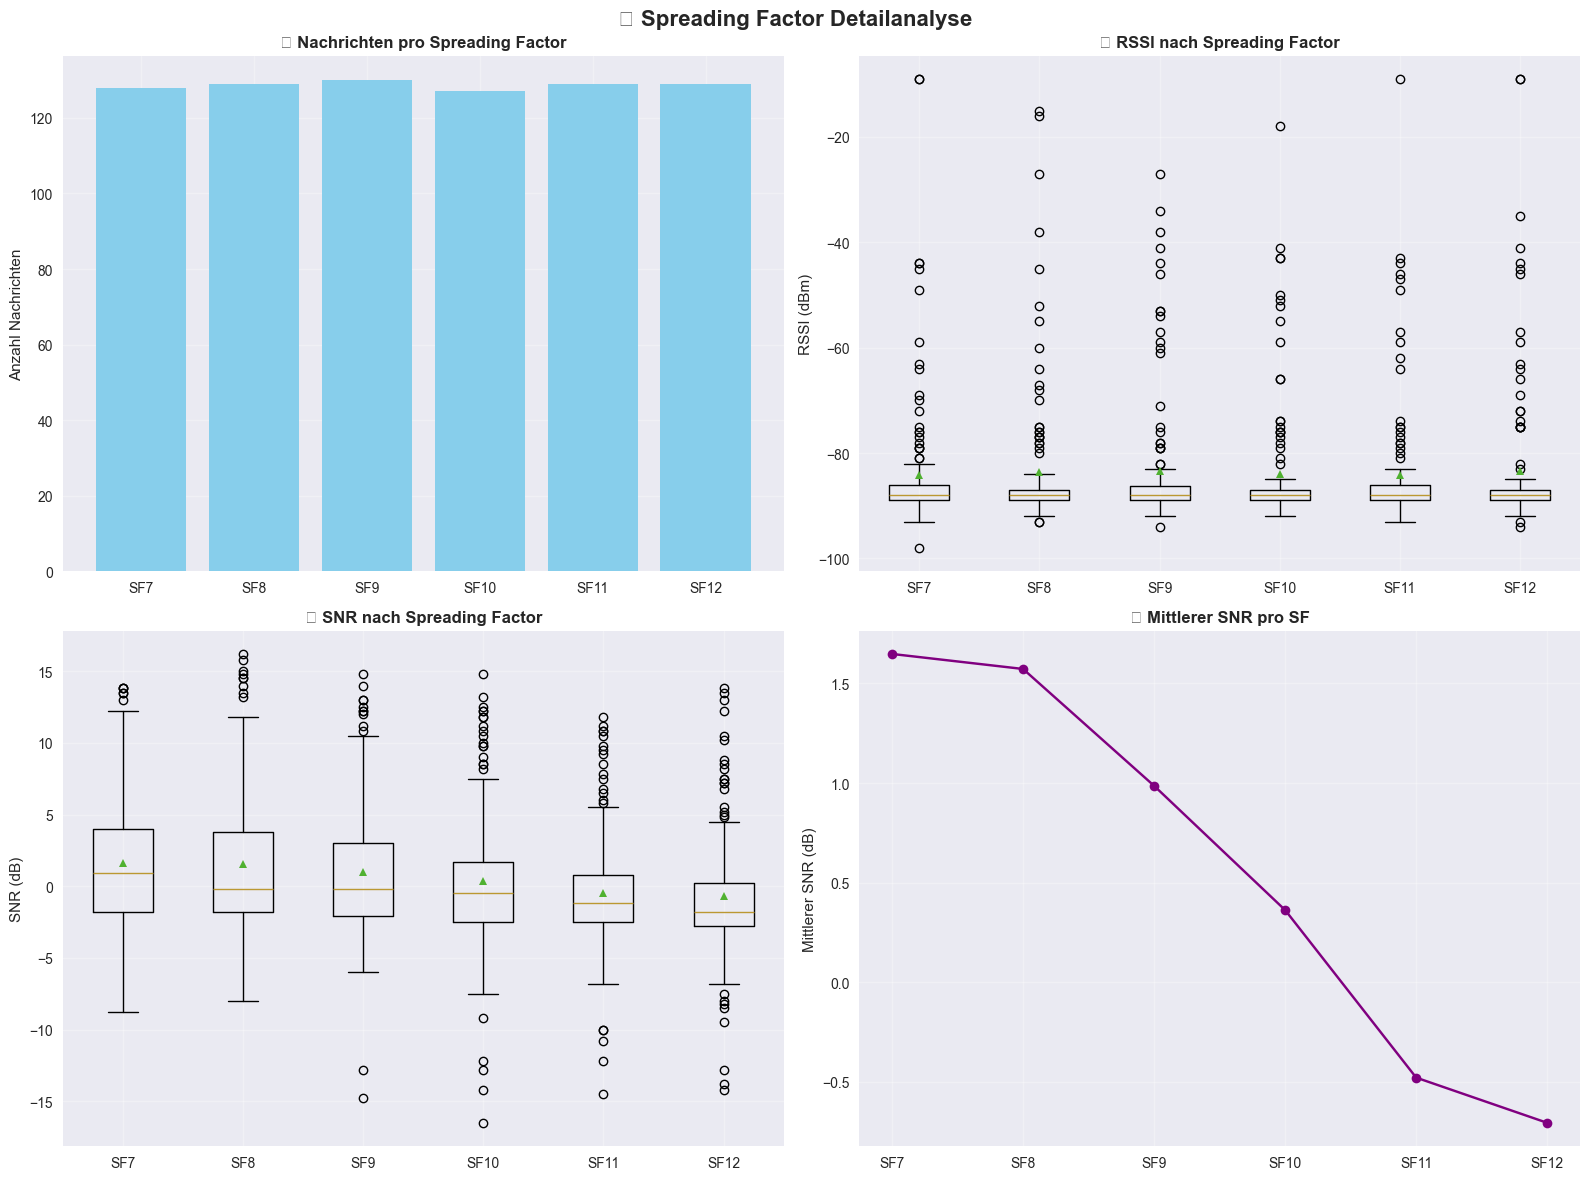


🔍 SF-KORRELATIONSANALYSE:
📈 SF vs RSSI Korrelation: 0.004
📈 SF vs SNR Korrelation: -0.174
📊 Schwache Korrelation: SF-Verhalten unabhängig von RSSI
📊 Schwache Korrelation: SF-Verhalten unabhängig von SNR


In [102]:
# 🎯 DETAILLIERTE SPREADING FACTOR ANALYSE
if len(df) > 0 and 'sf_numeric' in df.columns:
    print("🎯 DETAILLIERTE SPREADING FACTOR ANALYSE")
    print("=" * 60)
    
    # SF Grundstatistiken
    sf_stats = df['sf_numeric'].describe()
    print(f"🔄 SF Bereich: {sf_stats['min']:.0f} bis {sf_stats['max']:.0f}")
    print(f"📊 Durchschnittlicher SF: {sf_stats['mean']:.1f}")
    print(f"📈 Häufigster SF: {df['sf_numeric'].mode().iloc[0]:.0f}")
    
    # SF-Performance Analyse
    sf_performance = df.groupby('sf_numeric').agg({
        'rssi_dbm': ['mean', 'std', 'min', 'max'],
        'snr_db': ['mean', 'std', 'min', 'max'],
        'timestamp': 'count'
    }).round(2)
    
    print("\n📊 SF-Performance Übersicht:")
    for sf in sorted(df['sf_numeric'].unique()):
        if pd.notna(sf):
            sf_data = df[df['sf_numeric'] == sf]
            count = len(sf_data)
            avg_rssi = sf_data['rssi_dbm'].mean()
            avg_snr = sf_data['snr_db'].mean()
            percentage = (count / len(df)) * 100
            print(f"   SF{sf:.0f}: {count} Nachrichten ({percentage:.1f}%) | RSSI: {avg_rssi:.1f} dBm | SNR: {avg_snr:.1f} dB")

    # SF Visualisierungen
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🎯 Spreading Factor Detailanalyse', fontsize=16, fontweight='bold')

    # 1. SF vs Anzahl Nachrichten (Bar Plot)
    sf_counts = df['sf_numeric'].value_counts().sort_index()
    axes[0, 0].bar([f'SF{int(sf)}' for sf in sf_counts.index], sf_counts.values, color='skyblue')
    axes[0, 0].set_title('🔄 Nachrichten pro Spreading Factor', fontweight='bold')
    axes[0, 0].set_ylabel('Anzahl Nachrichten')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. SF vs RSSI (Box Plot)
    sf_list = sorted(df['sf_numeric'].dropna().unique())
    rssi_by_sf = [df[df['sf_numeric'] == sf]['rssi_dbm'].values for sf in sf_list]
    axes[0, 1].boxplot(rssi_by_sf, labels=[f'SF{int(sf)}' for sf in sf_list], showmeans=True)
    axes[0, 1].set_title('📶 RSSI nach Spreading Factor', fontweight='bold')
    axes[0, 1].set_ylabel('RSSI (dBm)')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. SF vs SNR (Box Plot)
    snr_by_sf = [df[(df['sf_numeric'] == sf) & pd.notna(df['snr_db'])]['snr_db'].values for sf in sf_list]
    axes[1, 0].boxplot(snr_by_sf, labels=[f'SF{int(sf)}' for sf in sf_list], showmeans=True)
    axes[1, 0].set_title('📡 SNR nach Spreading Factor', fontweight='bold')
    axes[1, 0].set_ylabel('SNR (dB)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. SF vs SNR Mittelwert (Line Plot)
    mean_snr_per_sf = [np.nanmean(snr) if len(snr) > 0 else np.nan for snr in snr_by_sf]
    axes[1, 1].plot([f'SF{int(sf)}' for sf in sf_list], mean_snr_per_sf, marker='o', color='purple')
    axes[1, 1].set_title('📈 Mittlerer SNR pro SF', fontweight='bold')
    axes[1, 1].set_ylabel('Mittlerer SNR (dB)')
    axes[1, 1].grid(True, alpha=0.3)
    
    
    plt.tight_layout()
    plt.show()
    
    # SF-Korrelationsanalyse
    print("\n🔍 SF-KORRELATIONSANALYSE:")
    print("=" * 40)
    
    # Korrelation zwischen SF und Signalqualität
    sf_rssi_corr = df['sf_numeric'].corr(df['rssi_dbm'])
    sf_snr_corr = df['sf_numeric'].corr(df['snr_db'])
    
    print(f"📈 SF vs RSSI Korrelation: {sf_rssi_corr:.3f}")
    print(f"📈 SF vs SNR Korrelation: {sf_snr_corr:.3f}")
    
    # Interpretation
    if sf_rssi_corr < -0.3:
        print("✅ Negative Korrelation: Höhere SF bei schlechterem RSSI (erwartetes Verhalten)")
    elif sf_rssi_corr > 0.3:
        print("⚠️ Positive Korrelation: Höhere SF bei besserem RSSI (unerwartet)")
    else:
        print("📊 Schwache Korrelation: SF-Verhalten unabhängig von RSSI")
    
    if sf_snr_corr < -0.3:
        print("✅ Negative Korrelation: Höhere SF bei schlechterem SNR (erwartetes Verhalten)")
    elif sf_snr_corr > 0.3:
        print("⚠️ Positive Korrelation: Höhere SF bei besserem SNR (unerwartet)")
    else:
        print("📊 Schwache Korrelation: SF-Verhalten unabhängig von SNR")
    
else:
    print("⚠️ Keine SF-Daten für Analyse verfügbar")

In [103]:
# Netzwerk-Parameter Statistiken
if len(df) > 0:
    print("📊 NETZWERK-PARAMETER STATISTIKEN")
    print("=" * 60)
    
    # RSSI Statistiken
    print("📶 RSSI (Received Signal Strength Indicator):")
    rssi_stats = df['rssi_dbm'].describe()
    print(f"   Durchschnitt: {rssi_stats['mean']:.2f} dBm")
    print(f"   Bereich: {rssi_stats['min']:.1f} bis {rssi_stats['max']:.1f} dBm")
    print(f"   Standardabweichung: {rssi_stats['std']:.2f} dBm")
    
    # SNR Statistiken
    print("\n📡 SNR (Signal-to-Noise Ratio):")
    snr_stats = df['snr_db'].describe()
    print(f"   Durchschnitt: {snr_stats['mean']:.2f} dB")
    print(f"   Bereich: {snr_stats['min']:.1f} bis {snr_stats['max']:.1f} dB")
    print(f"   Standardabweichung: {snr_stats['std']:.2f} dB")
    # Analyse der SNR-Robustheit
    low_snr_count = (df['snr_db'] < 0).sum()
    if low_snr_count > 0:
        print(f"   ✅ Robuste Verbindungen: {low_snr_count} Nachrichten mit SNR < 0 dB erfolgreich empfangen")
        print(f"   💪 Systemrobustheit: {(low_snr_count / len(df)) * 100:.1f}% funktionieren auch bei niedrigem SNR")
    
    # Spreading Factor Verteilung
    print("\n🔄 Spreading Factor Verteilung:")
    sf_counts = df['spreading_factor'].value_counts().sort_index()
    for sf, count in sf_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   {sf}: {count} Nachrichten ({percentage:.1f}%)")
    
    # Frequenz Verteilung
    print("\n📻 Frequenz Verteilung:")
    freq_counts = df['frequency'].value_counts().sort_index()
    for freq, count in freq_counts.items():
        percentage = (count / len(df)) * 100
        freq_mhz = freq / 1_000_000  # Hz zu MHz
        print(f"   {freq_mhz:.1f} MHz: {count} Nachrichten ({percentage:.1f}%)")
    
    # Frame Counter Analyse
    if 'fcnt' in df.columns:
        print("\n🔢 Frame Counter:")
        fcnt_stats = df['fcnt'].describe()
        print(f"   Bereich: {fcnt_stats['min']:.0f} bis {fcnt_stats['max']:.0f}")
        if len(df) > 1:
            packet_loss = (fcnt_stats['max'] - fcnt_stats['min'] + 1) - len(df)
            if packet_loss > 0:
                loss_rate = (packet_loss / (fcnt_stats['max'] - fcnt_stats['min'] + 1)) * 100
                print(f"   Möglicher Paketverlust: {packet_loss} Pakete ({loss_rate:.1f}%)")
            else:
                print(f"   ✅ Kein Paketverlust erkannt")

📊 NETZWERK-PARAMETER STATISTIKEN
📶 RSSI (Received Signal Strength Indicator):
   Durchschnitt: -83.79 dBm
   Bereich: -98.0 bis -9.0 dBm
   Standardabweichung: 12.84 dBm

📡 SNR (Signal-to-Noise Ratio):
   Durchschnitt: 0.56 dB
   Bereich: -16.5 bis 16.2 dB
   Standardabweichung: 5.21 dB
   ✅ Robuste Verbindungen: 432 Nachrichten mit SNR < 0 dB erfolgreich empfangen
   💪 Systemrobustheit: 56.0% funktionieren auch bei niedrigem SNR

🔄 Spreading Factor Verteilung:
   SF10: 127 Nachrichten (16.5%)
   SF11: 129 Nachrichten (16.7%)
   SF12: 129 Nachrichten (16.7%)
   SF7: 128 Nachrichten (16.6%)
   SF8: 129 Nachrichten (16.7%)
   SF9: 130 Nachrichten (16.8%)

📻 Frequenz Verteilung:
   867.1 MHz: 1 Nachrichten (0.1%)
   867.5 MHz: 1 Nachrichten (0.1%)
   868.1 MHz: 240 Nachrichten (31.1%)
   868.3 MHz: 258 Nachrichten (33.4%)
   868.5 MHz: 272 Nachrichten (35.2%)

🔢 Frame Counter:
   Bereich: 0 bis 692
   ✅ Kein Paketverlust erkannt


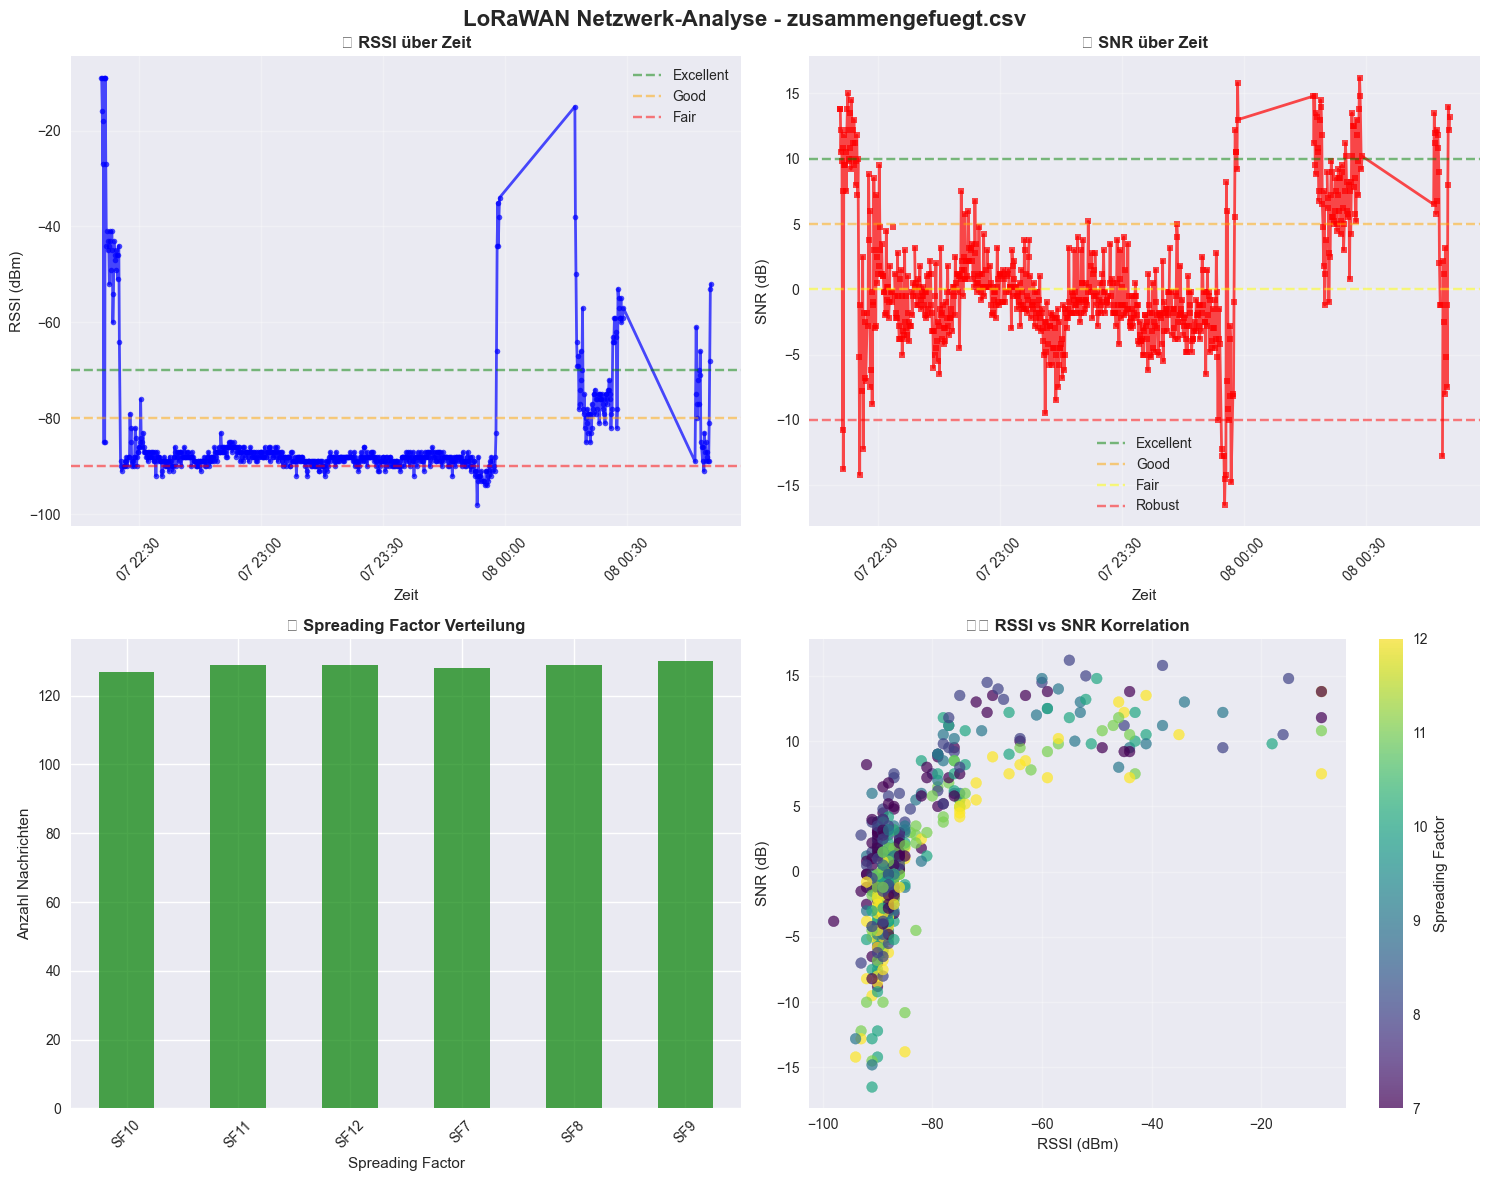

In [104]:
# LoRaWAN-Netzwerk Visualisierungen
if len(df) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'LoRaWAN Netzwerk-Analyse - {selected_file}', fontsize=16, fontweight='bold')
    
    # 1. RSSI über Zeit
    axes[0, 0].plot(df['timestamp'], df['rssi_dbm'], 'b-', alpha=0.7, linewidth=2, marker='o', markersize=4)
    axes[0, 0].set_title('📶 RSSI über Zeit', fontweight='bold')
    axes[0, 0].set_xlabel('Zeit')
    axes[0, 0].set_ylabel('RSSI (dBm)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Qualitätszonen einzeichnen
    axes[0, 0].axhline(-70, color='green', linestyle='--', alpha=0.5, label='Excellent')
    axes[0, 0].axhline(-80, color='orange', linestyle='--', alpha=0.5, label='Good')
    axes[0, 0].axhline(-90, color='red', linestyle='--', alpha=0.5, label='Fair')
    axes[0, 0].legend()
    
    # 2. SNR über Zeit
    axes[0, 1].plot(df['timestamp'], df['snr_db'], 'r-', alpha=0.7, linewidth=2, marker='s', markersize=4)
    axes[0, 1].set_title('📡 SNR über Zeit', fontweight='bold')
    axes[0, 1].set_xlabel('Zeit')
    axes[0, 1].set_ylabel('SNR (dB)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # SNR Qualitätszonen
    axes[0, 1].axhline(10, color='green', linestyle='--', alpha=0.5, label='Excellent')
    axes[0, 1].axhline(5, color='orange', linestyle='--', alpha=0.5, label='Good')
    axes[0, 1].axhline(0, color='yellow', linestyle='--', alpha=0.5, label='Fair')
    axes[0, 1].axhline(-10, color='red', linestyle='--', alpha=0.5, label='Robust')
    axes[0, 1].legend()
    
    # 3. Spreading Factor Verteilung
    sf_counts = df['spreading_factor'].value_counts().sort_index()
    sf_counts.plot(kind='bar', ax=axes[1, 0], color='green', alpha=0.7)
    axes[1, 0].set_title('🔄 Spreading Factor Verteilung', fontweight='bold')
    axes[1, 0].set_xlabel('Spreading Factor')
    axes[1, 0].set_ylabel('Anzahl Nachrichten')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. RSSI vs SNR Scatter mit Spreading Factor Farben
    if 'sf_numeric' in df.columns:
        scatter = axes[1, 1].scatter(df['rssi_dbm'], df['snr_db'], c=df['sf_numeric'], 
                                   cmap='viridis', alpha=0.7, s=60)
        plt.colorbar(scatter, ax=axes[1, 1], label='Spreading Factor')
    else:
        axes[1, 1].scatter(df['rssi_dbm'], df['snr_db'], alpha=0.7, s=60)
    
    axes[1, 1].set_title('📶📡 RSSI vs SNR Korrelation', fontweight='bold')
    axes[1, 1].set_xlabel('RSSI (dBm)')
    axes[1, 1].set_ylabel('SNR (dB)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Zu wenig Daten für Zeitreihen-Visualisierungen")

In [105]:
# Netzwerk-Performance Zusammenfassung
if len(df) > 0:
    print("\n" + "=" * 80)
    print("🎯 LoRaWAN NETZWERK-PERFORMANCE ZUSAMMENFASSUNG")
    print("=" * 80)
    
    # Berechne wichtige Metriken
    rssi_quality, snr_quality = analyze_signal_quality(df['rssi_dbm'], df['snr_db'])
    excellent_rssi_pct = (rssi_quality == 'Excellent').sum() / len(df) * 100
    excellent_snr_pct = (snr_quality == 'Excellent').sum() / len(df) * 100
    
    summary = {
        'Dateiname': selected_file,
        'Analysezeitpunkt': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Gesamtnachrichten': len(df),
        'Session_Zeitraum': f"{df['timestamp'].min()} bis {df['timestamp'].max()}",
        'Session_Dauer': str(df['timestamp'].max() - df['timestamp'].min()).split('.')[0],
        'Durchschnittliche_RSSI': f"{df['rssi_dbm'].mean():.2f} dBm",
        'RSSI_Bereich': f"{df['rssi_dbm'].min():.1f} bis {df['rssi_dbm'].max():.1f} dBm",
        'Durchschnittliche_SNR': f"{df['snr_db'].mean():.2f} dB",
        'SNR_Bereich': f"{df['snr_db'].min():.1f} bis {df['snr_db'].max():.1f} dB",
        'Häufigster_SF': df['spreading_factor'].mode().iloc[0] if not df['spreading_factor'].mode().empty else 'N/A',
        'Anzahl_Frequenzen': df['frequency'].nunique(),
        'Qualität_Excellent_RSSI': f"{excellent_rssi_pct:.1f}%",
        'Qualität_Excellent_SNR': f"{excellent_snr_pct:.1f}%",
        'Unique_Devices': df['device_eui'].nunique(),
        'Unique_Gateways': df['gateway_id'].nunique()
    }
    
    # Durchschnittliches Nachrichtenintervall
    if len(df) > 1:
        df_sorted = df.sort_values('timestamp')
        time_diffs = df_sorted['timestamp'].diff().dt.total_seconds().dropna()
        summary['Durchschnittliches_Intervall'] = f"{time_diffs.mean():.2f} Sekunden"
    
    # Ausgabe der Zusammenfassung
    for key, value in summary.items():
        print(f"{key.replace('_', ' ')}: {value}")
    
    print("\n" + "=" * 80)
    print("📤 EXPORT-OPTIONEN")
    print("=" * 80)
    print("Sie können die Analyseergebnisse exportieren:")
    print("1. Netzwerkdaten als CSV: df.to_csv('lorawan_network_analysis.csv', index=False)")
    print("2. Zusammenfassung als JSON: import json; json.dump(summary, open('network_summary.json', 'w'), indent=2)")
    print("3. Grafiken als PNG: plt.savefig('lorawan_plots.png', dpi=300, bbox_inches='tight')")
    
    print("\n🎉 LoRaWAN Netzwerk-Analyse abgeschlossen!")
else:
    print("❌ Keine Daten verfügbar für Analyse")


🎯 LoRaWAN NETZWERK-PERFORMANCE ZUSAMMENFASSUNG
Dateiname: zusammengefuegt.csv
Analysezeitpunkt: 2025-08-03 23:43:58
Gesamtnachrichten: 772
Session Zeitraum: 2025-07-07 22:20:40 bis 2025-07-08 00:50:37
Session Dauer: 0 days 02:29:57
Durchschnittliche RSSI: -83.79 dBm
RSSI Bereich: -98.0 bis -9.0 dBm
Durchschnittliche SNR: 0.56 dB
SNR Bereich: -16.5 bis 16.2 dB
Häufigster SF: SF9
Anzahl Frequenzen: 5
Qualität Excellent RSSI: 9.1%
Qualität Excellent SNR: 7.5%
Unique Devices: 1
Unique Gateways: 1
Durchschnittliches Intervall: 11.67 Sekunden

📤 EXPORT-OPTIONEN
Sie können die Analyseergebnisse exportieren:
1. Netzwerkdaten als CSV: df.to_csv('lorawan_network_analysis.csv', index=False)
2. Zusammenfassung als JSON: import json; json.dump(summary, open('network_summary.json', 'w'), indent=2)
3. Grafiken als PNG: plt.savefig('lorawan_plots.png', dpi=300, bbox_inches='tight')

🎉 LoRaWAN Netzwerk-Analyse abgeschlossen!



📊 VISUELLE DARSTELLUNG: SPREADING FACTOR UND SNR


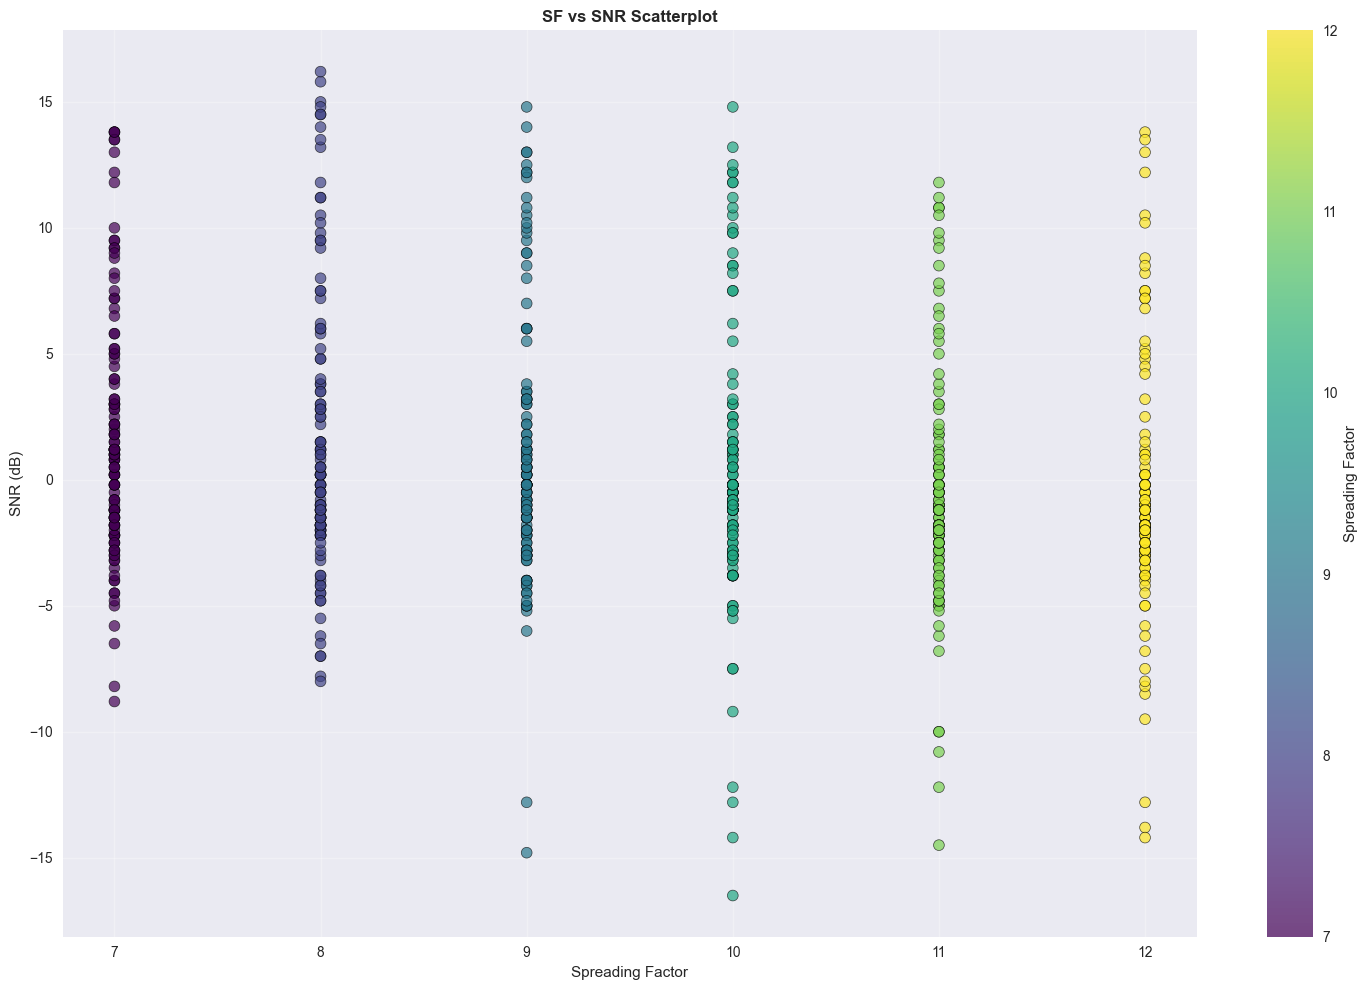

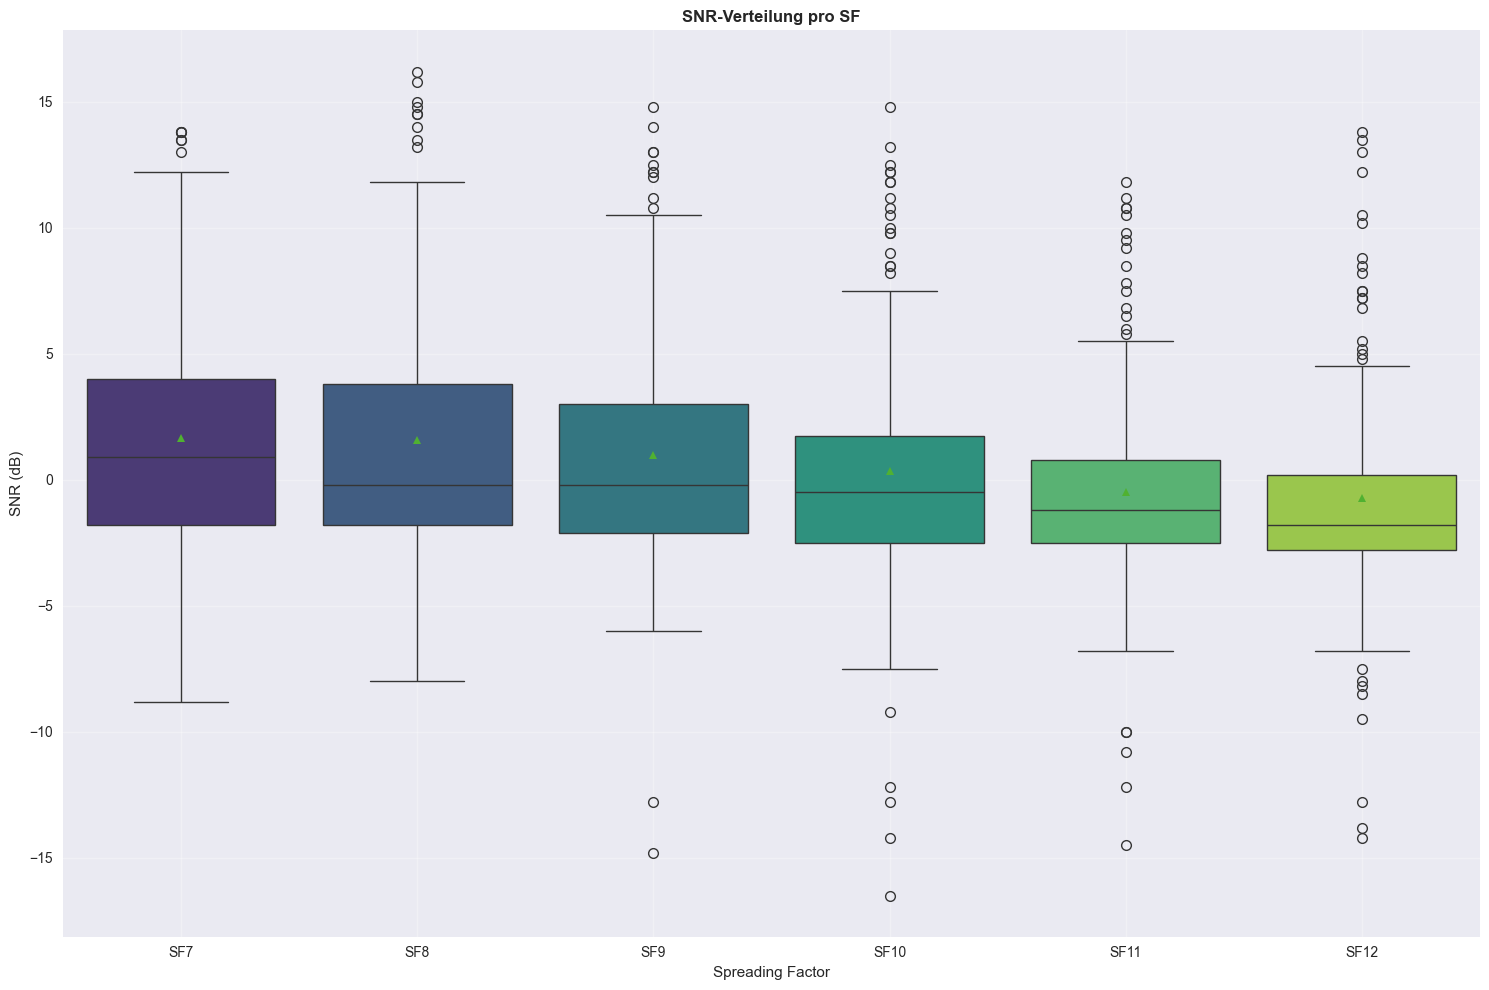

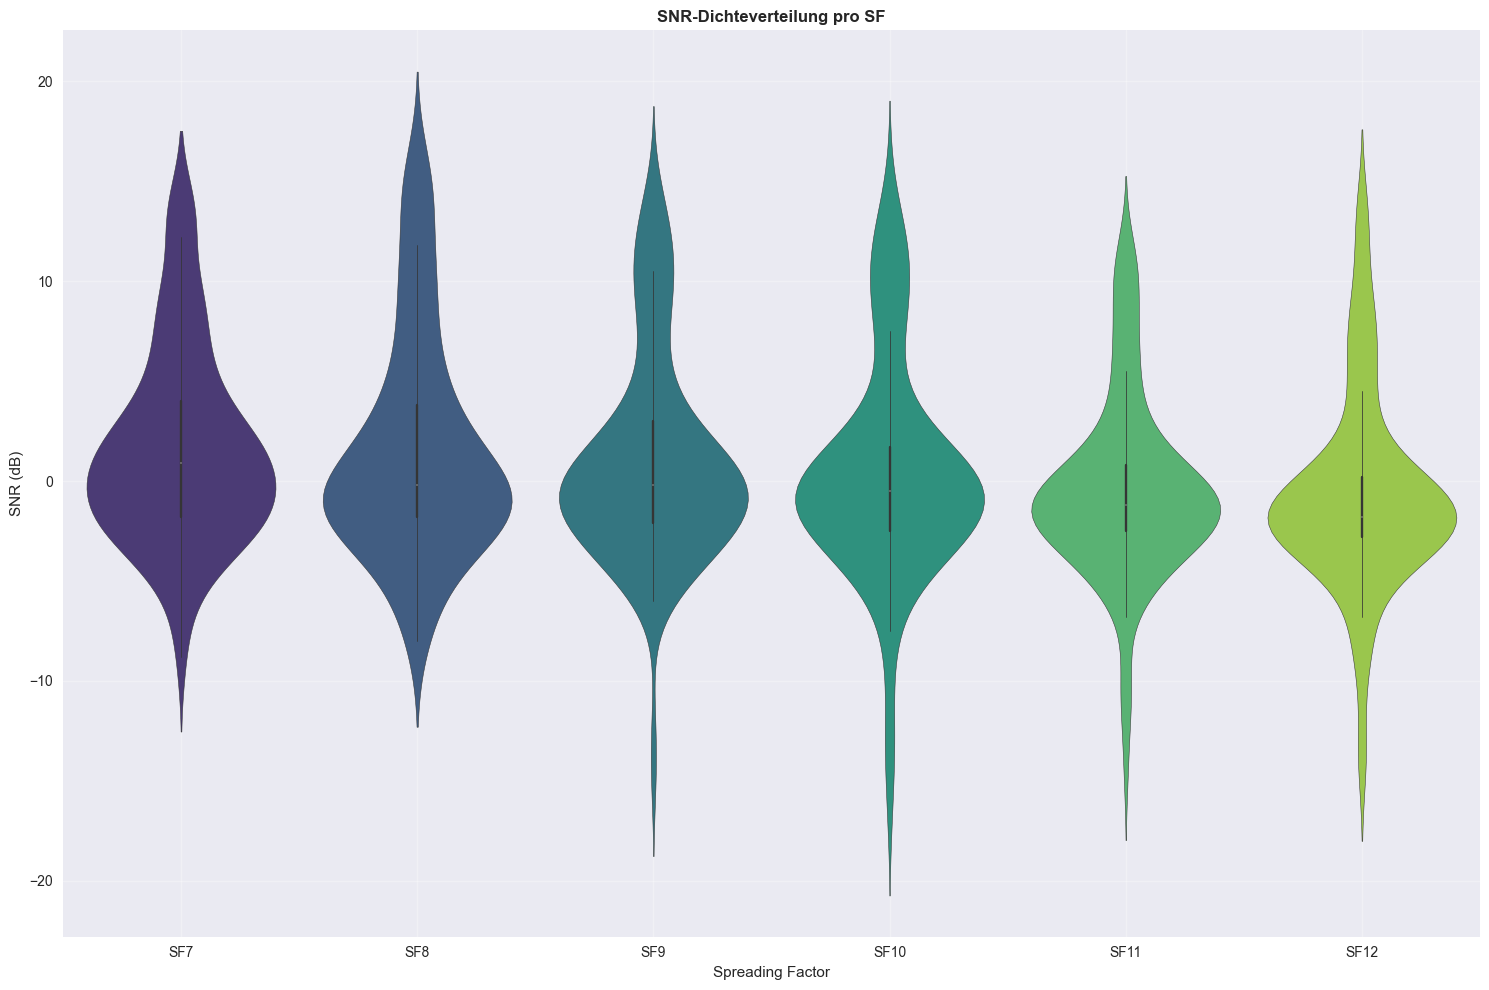

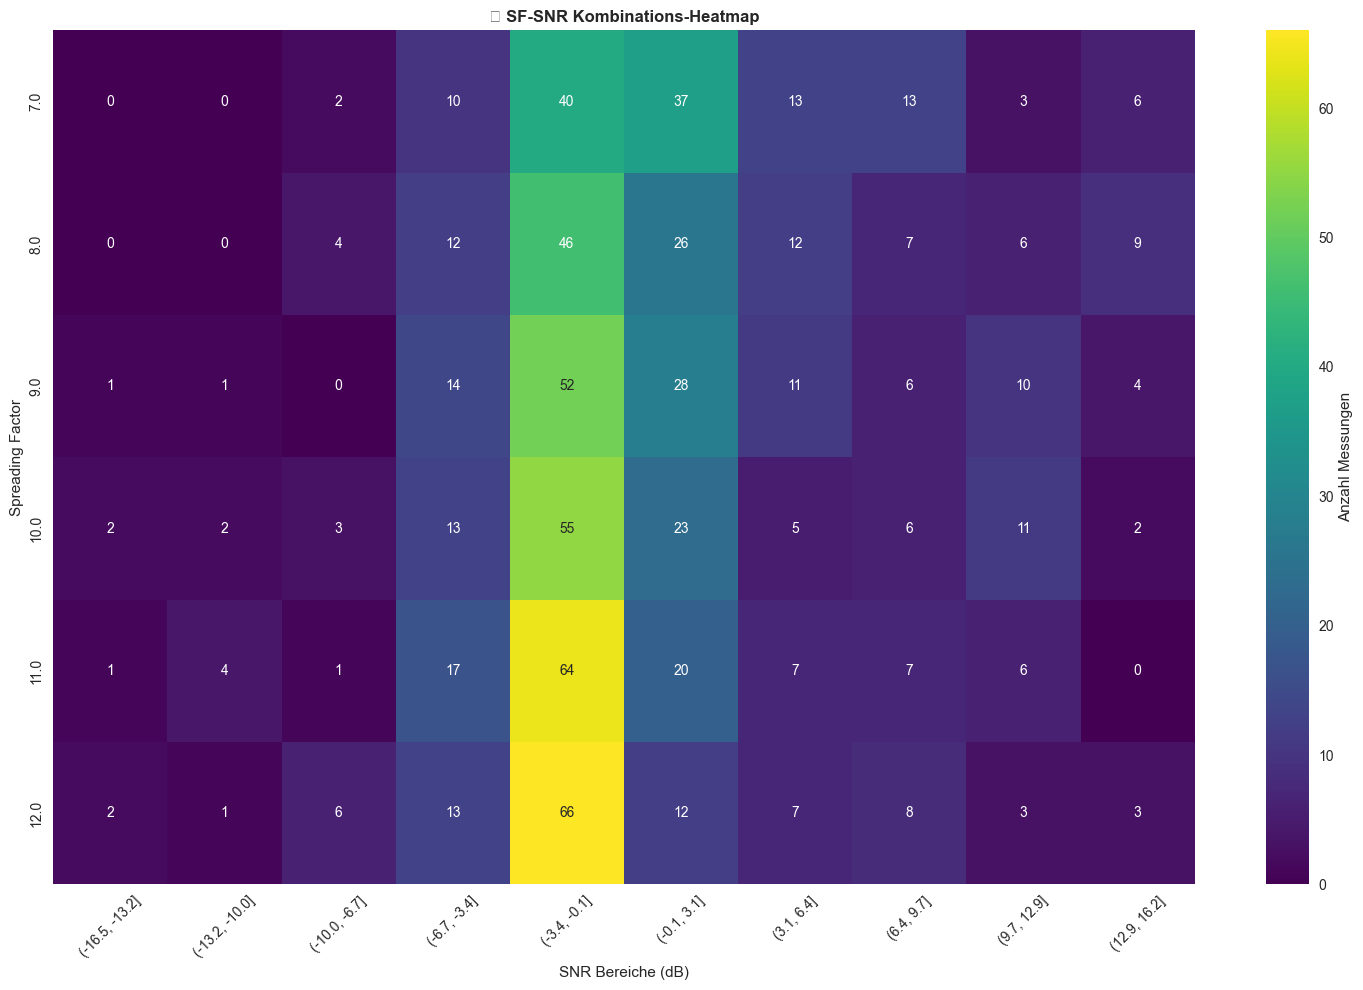


📈 STATISTISCHE AUSWERTUNG PRO SF:
            count  mean   std   min   max  median
sf_numeric                                       
7.0           124  1.65  4.89  -8.8  13.8     0.9
8.0           122  1.57  5.61  -8.0  16.2    -0.2
9.0           127  0.99  5.23 -14.8  14.8    -0.2
10.0          122  0.36  5.54 -16.5  14.8    -0.5
11.0          127 -0.48  4.57 -14.5  11.8    -1.2
12.0          121 -0.71  4.97 -14.2  13.8    -1.8

✅ Bester SF (höchste durchschnittliche SNR): SF7 mit 1.65 dB
❌ Schlechtester SF (niedrigste durchschnittliche SNR): SF12 mit -0.71 dB

💡 EMPFEHLUNGEN:
SF7: 🟠 Fair - 1.65 dB (n=124)
SF8: 🟠 Fair - 1.57 dB (n=122)
SF9: 🟠 Fair - 0.99 dB (n=127)
SF10: 🟠 Fair - 0.36 dB (n=122)
SF11: 💪 Robust (niedriges SNR aber funktional) - -0.48 dB (n=127)
SF12: 💪 Robust (niedriges SNR aber funktional) - -0.71 dB (n=121)

🎯 Analyse der SF-SNR Beziehungen abgeschlossen!


In [106]:
# Visuelle Darstellung der einzelnen SF und die dazugehörigen SNR Daten
if len(df) > 0:
    print("\n" + "=" * 80)
    print("📊 VISUELLE DARSTELLUNG: SPREADING FACTOR UND SNR")
    print("=" * 80)
    
    # 1. Scatterplot: SF vs SNR
    plt.figure(figsize=(15, 10))
    if 'sf_numeric' in df.columns and 'snr_db' in df.columns:
        scatter = plt.scatter(df['sf_numeric'], df['snr_db'], 
                              c=df['sf_numeric'], cmap='viridis', 
                              alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
        plt.colorbar(scatter, label='Spreading Factor')
        plt.xlabel('Spreading Factor')
        plt.ylabel('SNR (dB)')
        plt.title('SF vs SNR Scatterplot', fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 2. Box Plot für SNR pro SF
    plt.figure(figsize=(15, 10))
    if 'sf_label' in df_plot.columns and 'snr_db' in df_plot.columns:
        sf_order = sorted(df_plot['sf_label'].unique(), key=lambda x: int(x.replace('SF', '')))
        sns.boxplot(data=df_plot, x='sf_label', y='snr_db', palette='viridis', order=sf_order, showmeans=True)
        plt.xlabel('Spreading Factor')
        plt.ylabel('SNR (dB)')
        plt.title('SNR-Verteilung pro SF', fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 3. Violin Plot für detaillierte Verteilung
    plt.figure(figsize=(15, 10))
    if 'sf_label' in df_plot.columns and 'snr_db' in df_plot.columns:
        sf_order = sorted(df_plot['sf_label'].unique(), key=lambda x: int(x.replace('SF', '')))
        sns.violinplot(data=df_plot, x='sf_label', y='snr_db', palette='viridis', order=sf_order)
        plt.xlabel('Spreading Factor')
        plt.ylabel('SNR (dB)')
        plt.title('SNR-Dichteverteilung pro SF', fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 4. Heatmap für SF-SNR Kombinationen
    plt.figure(figsize=(15, 10))
    if not heatmap_data.empty:
        sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis', 
                    cbar_kws={'label': 'Anzahl Messungen'})
        plt.xlabel('SNR Bereiche (dB)')
        plt.ylabel('Spreading Factor')
        plt.title('🔥 SF-SNR Kombinations-Heatmap', fontweight='bold')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Zusätzliche statistische Analyse
    print("\n📈 STATISTISCHE AUSWERTUNG PRO SF:")
    print("=" * 50)
    
    if 'sf_numeric' in df.columns and 'snr_db' in df.columns:
        sf_snr_stats = df.groupby('sf_numeric')['snr_db'].agg([
            'count', 'mean', 'std', 'min', 'max', 'median'
        ]).round(2)
        
        print(sf_snr_stats)
        
        # Beste und schlechteste SF Performance
        best_sf = sf_snr_stats['mean'].idxmax()
        worst_sf = sf_snr_stats['mean'].idxmin()
        
        print(f"\n✅ Bester SF (höchste durchschnittliche SNR): SF{int(best_sf)} mit {sf_snr_stats.loc[best_sf, 'mean']:.2f} dB")
        print(f"❌ Schlechtester SF (niedrigste durchschnittliche SNR): SF{int(worst_sf)} mit {sf_snr_stats.loc[worst_sf, 'mean']:.2f} dB")
        
        # Empfehlungen
        print("\n💡 EMPFEHLUNGEN:")
        print("=" * 30)
        
        for sf in sorted(df['sf_numeric'].unique()):
            if pd.notna(sf):
                sf_int = int(sf)
                mean_snr = sf_snr_stats.loc[sf, 'mean']
                count = sf_snr_stats.loc[sf, 'count']
                
                if mean_snr >= 10:
                    status = "✅ Excellent"
                elif mean_snr >= 5:
                    status = "🟡 Good"
                elif mean_snr >= 0:
                    status = "🟠 Fair"
                elif mean_snr >= -10:
                    status = "💪 Robust (niedriges SNR aber funktional)"
                else:
                    status = "❌ Poor"
                
                print(f"SF{sf_int}: {status} - {mean_snr:.2f} dB (n={count})")
    
    print("\n🎯 Analyse der SF-SNR Beziehungen abgeschlossen!")
else:
    print("⚠️ Keine Daten für SF-SNR Visualisierung verfügbar")

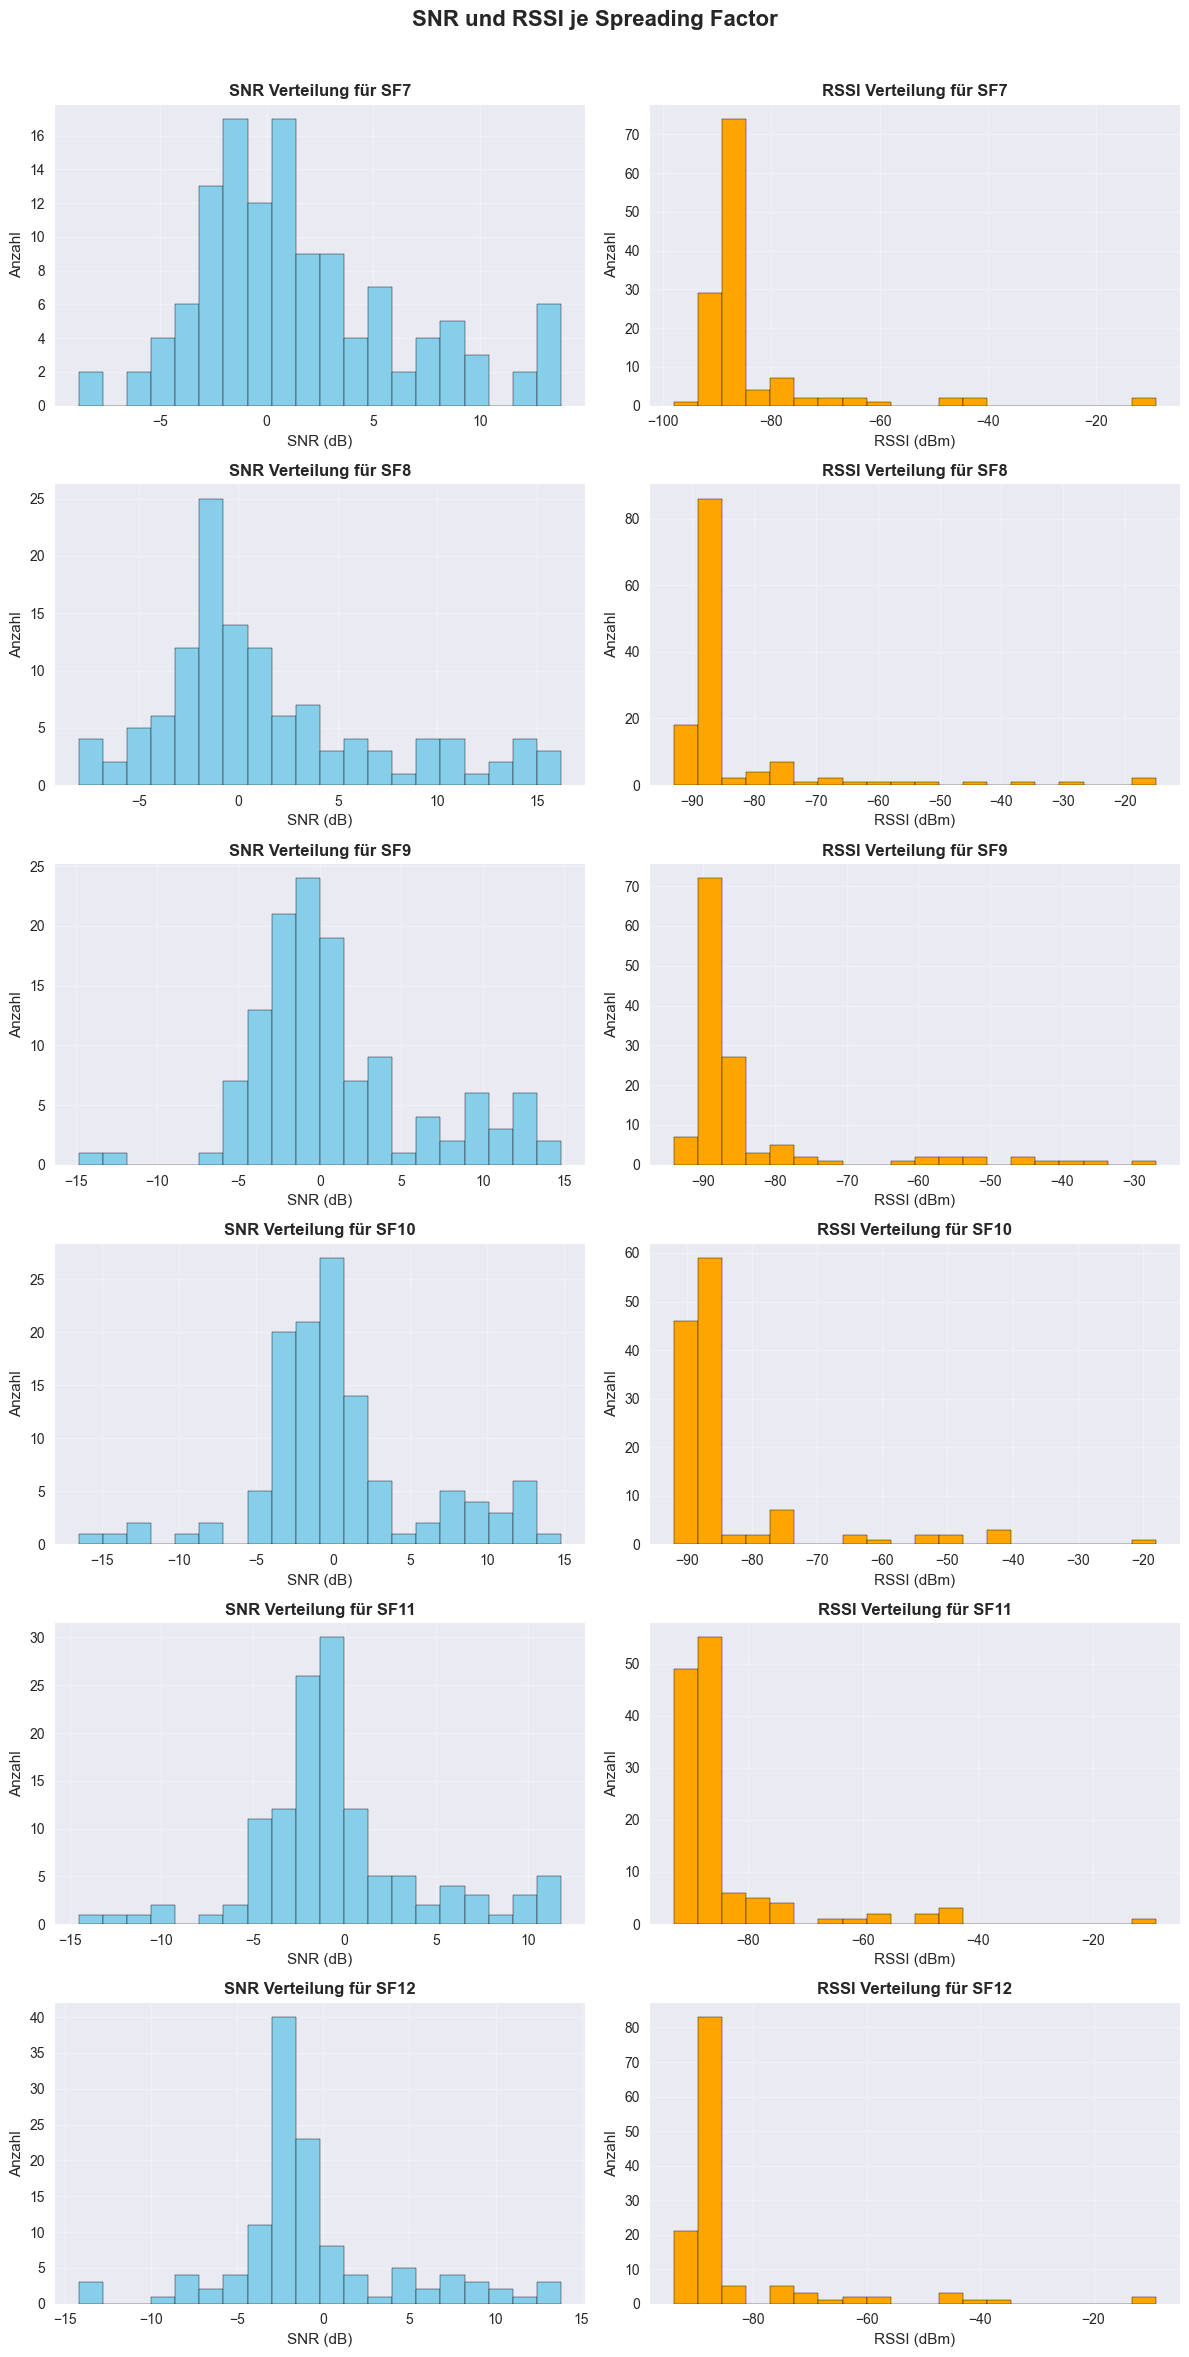

In [107]:
# Einzelne Diagramme für SNR und RSSI je Spreading Factor (SF)
if len(df) > 0 and 'sf_numeric' in df.columns:
    sf_unique = sorted(df['sf_numeric'].dropna().unique())
    n_sf = len(sf_unique)
    fig, axes = plt.subplots(n_sf, 2, figsize=(12, 4 * n_sf))
    fig.suptitle('SNR und RSSI je Spreading Factor', fontsize=16, fontweight='bold')

    for i, sf in enumerate(sf_unique):
        sf_data = df[df['sf_numeric'] == sf]
        # SNR Histogramm
        axes[i, 0].hist(sf_data['snr_db'].dropna(), bins=20, color='skyblue', edgecolor='black')
        axes[i, 0].set_title(f'SNR Verteilung für SF{int(sf)}', fontweight='bold')
        axes[i, 0].set_xlabel('SNR (dB)')
        axes[i, 0].set_ylabel('Anzahl')
        axes[i, 0].grid(True, alpha=0.3)
        # RSSI Histogramm
        axes[i, 1].hist(sf_data['rssi_dbm'].dropna(), bins=20, color='orange', edgecolor='black')
        axes[i, 1].set_title(f'RSSI Verteilung für SF{int(sf)}', fontweight='bold')
        axes[i, 1].set_xlabel('RSSI (dBm)')
        axes[i, 1].set_ylabel('Anzahl')
        axes[i, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
else:
    print("⚠️ Keine SF-Daten für Einzel-Diagramme verfügbar")

Korrelationsmatrix (RSSI, SNR und SF):
            rssi_dbm    snr_db  sf_numeric
rssi_dbm    1.000000  0.723434    0.003656
snr_db      0.723434  1.000000   -0.173596
sf_numeric  0.003656 -0.173596    1.000000


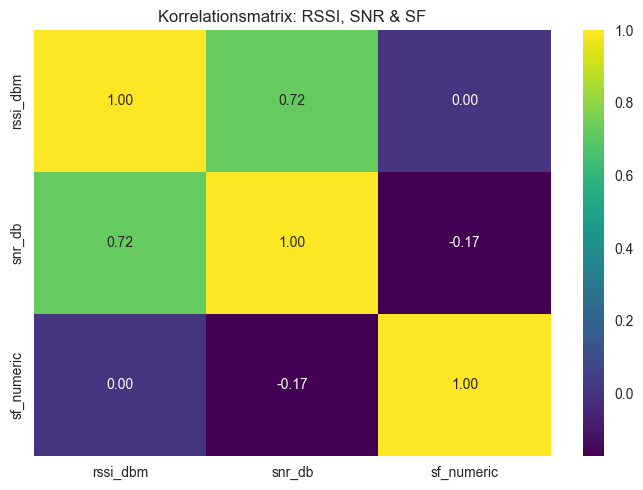

In [116]:
# Korrelationsmatrix für RSSI, SNR und Spreading Factor berechnen und anzeigen
corr_df = pd.DataFrame({
	'rssi_dbm': df.loc[df_plot.index, 'rssi_dbm'],
	'snr_db': df_plot['snr_db'],
	'sf_numeric': df_plot['sf_numeric']
})
corr_matrix = corr_df.corr()
print("Korrelationsmatrix (RSSI, SNR und SF):")
print(corr_matrix)

# Optional: Heatmap zur Visualisierung
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Korrelationsmatrix: RSSI, SNR & SF')
plt.tight_layout()
plt.show()

Schwellenwert für die unteren 10% der RSSI-Werte: -90.00 dBm


,sf_numeric,snr_db,sf_label,norm_snr,RSSI
35,10.0,-14.2,SF10,-0.157778,-90
36,11.0,-1.2,SF11,-0.013187,-91
37,8.0,-7.8,SF8,-0.086667,-90
38,9.0,2.5,SF9,0.027778,-90
39,10.0,-12.2,SF10,-0.135556,-90
...,...,...,...,...,...
649,12.0,-8.2,SF12,-0.089130,-92
652,9.0,-14.8,SF9,-0.162637,-91
653,12.0,-8.0,SF12,-0.088889,-90
654,7.0,-8.2,SF7,-0.090110,-91


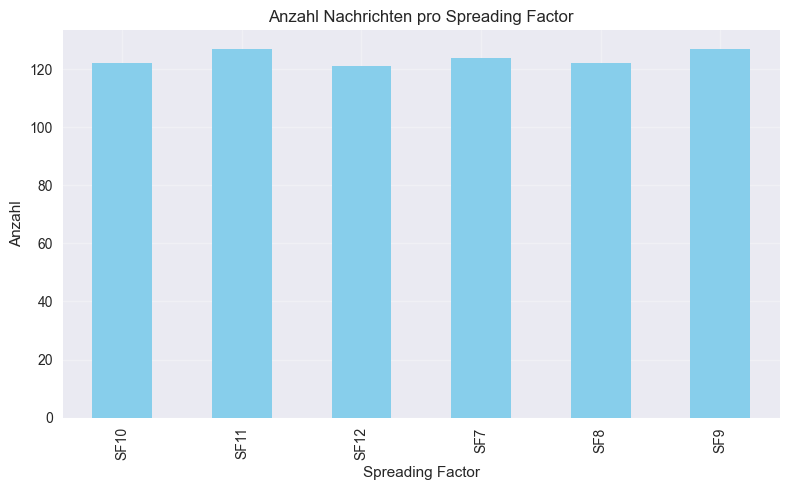

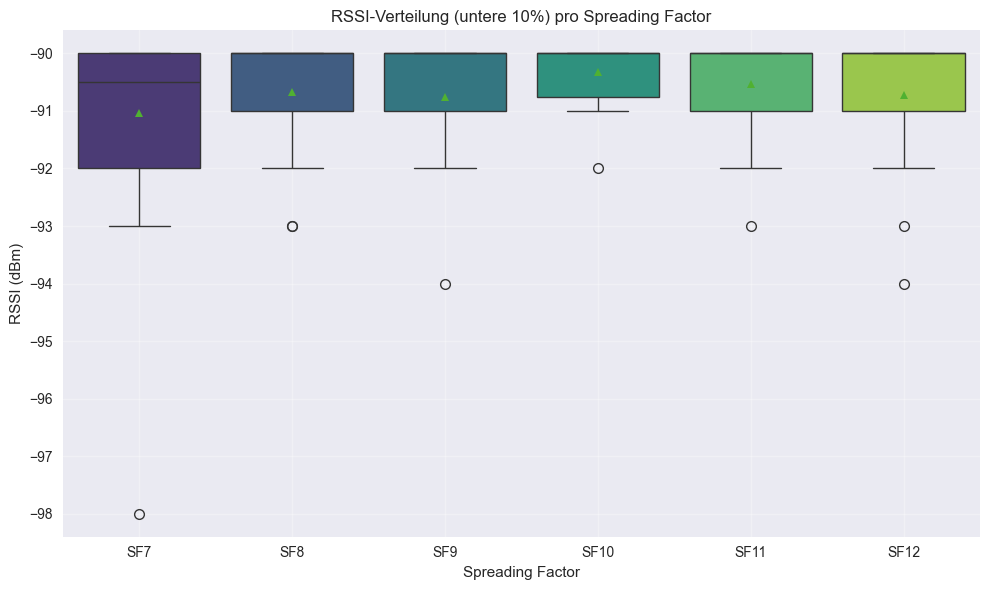

In [ ]:
# Zeige die unteren 10% der RSSI-Werte aus df_plot
df_plot['RSSI'] = df.loc[df_plot.index, 'rssi_dbm']
rssi_10pct_threshold = df_plot['RSSI'].quantile(0.10)
df_rssi_low10 = df_plot[df_plot['RSSI'] <= rssi_10pct_threshold]
print(f"Schwellenwert für die unteren 10% der RSSI-Werte: {rssi_10pct_threshold:.2f} dBm")
display(df_rssi_low10)

# Diagramm: Anzahl der Nachrichten pro Spreading Factor (SF)
plt.figure(figsize=(8, 5))
sf_counts = df_plot['sf_label'].value_counts().sort_index()
sf_counts.plot(kind='bar', color='skyblue')
plt.title('Anzahl Nachrichten pro Spreading Factor')
plt.xlabel('Spreading Factor')
plt.ylabel('Anzahl')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Boxplot der RSSI-Werte für die unteren 10% nach Spreading Factor
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_rssi_low10, x='sf_label', y='RSSI', palette='viridis', order=sf_order, showmeans=True)
plt.title('RSSI-Verteilung (untere 10%) pro Spreading Factor')
plt.xlabel('Spreading Factor')
plt.ylabel('RSSI (dBm)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


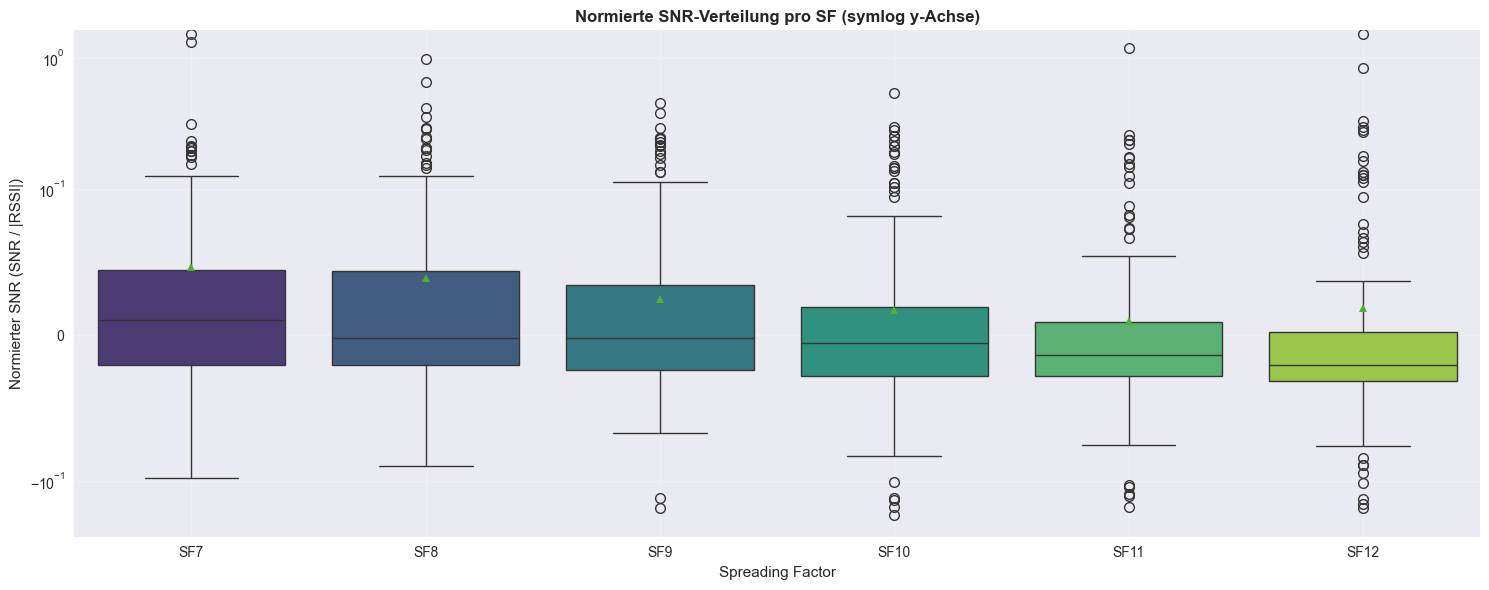


WICHTIGSTE WERTE PRO SPREADING FACTOR


,Anzahl,Mittelwert_norm_SNR,Median_norm_SNR,Min_norm_SNR,Max_norm_SNR,Mittelwert_SNR,Median_SNR,Min_SNR,Max_SNR,Mittelwert_RSSI,Median_RSSI,Min_RSSI,Max_RSSI
sf_label,,,,,,,,,,,,,
SF7,124,0.046,0.010,-0.098,1.533,1.65,0.90,-8.80,13.80,-83.92,-88.00,-98,-9
SF8,122,0.039,-0.002,-0.090,0.987,1.57,-0.20,-8.00,16.20,-83.40,-88.00,-93,-15
SF9,127,0.025,-0.002,-0.163,0.452,0.99,-0.20,-14.80,14.80,-83.34,-88.00,-94,-27
SF10,122,0.017,-0.006,-0.181,0.544,0.36,-0.50,-16.50,14.80,-83.93,-88.00,-92,-18
SF11,127,0.010,-0.013,-0.159,1.200,-0.48,-1.20,-14.50,11.80,-84.15,-88.00,-93,-9
SF12,121,0.018,-0.020,-0.162,1.533,-0.71,-1.80,-14.20,13.80,-83.14,-88.00,-94,-9


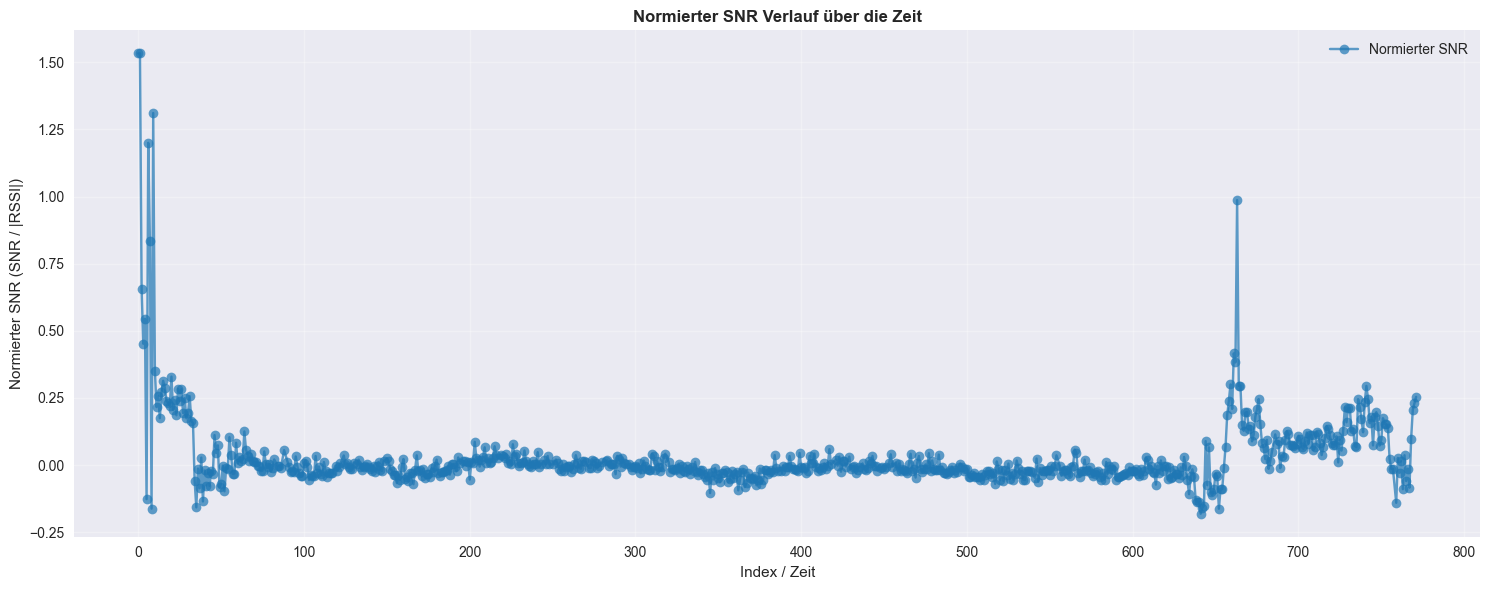

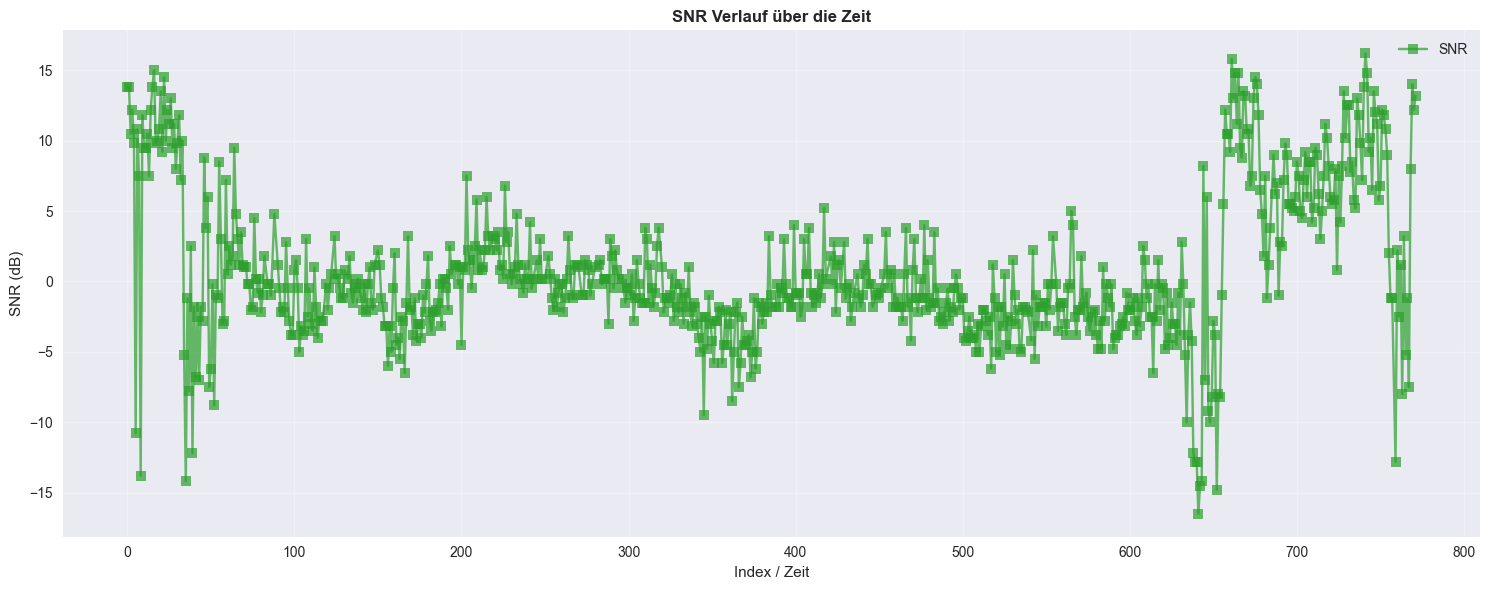

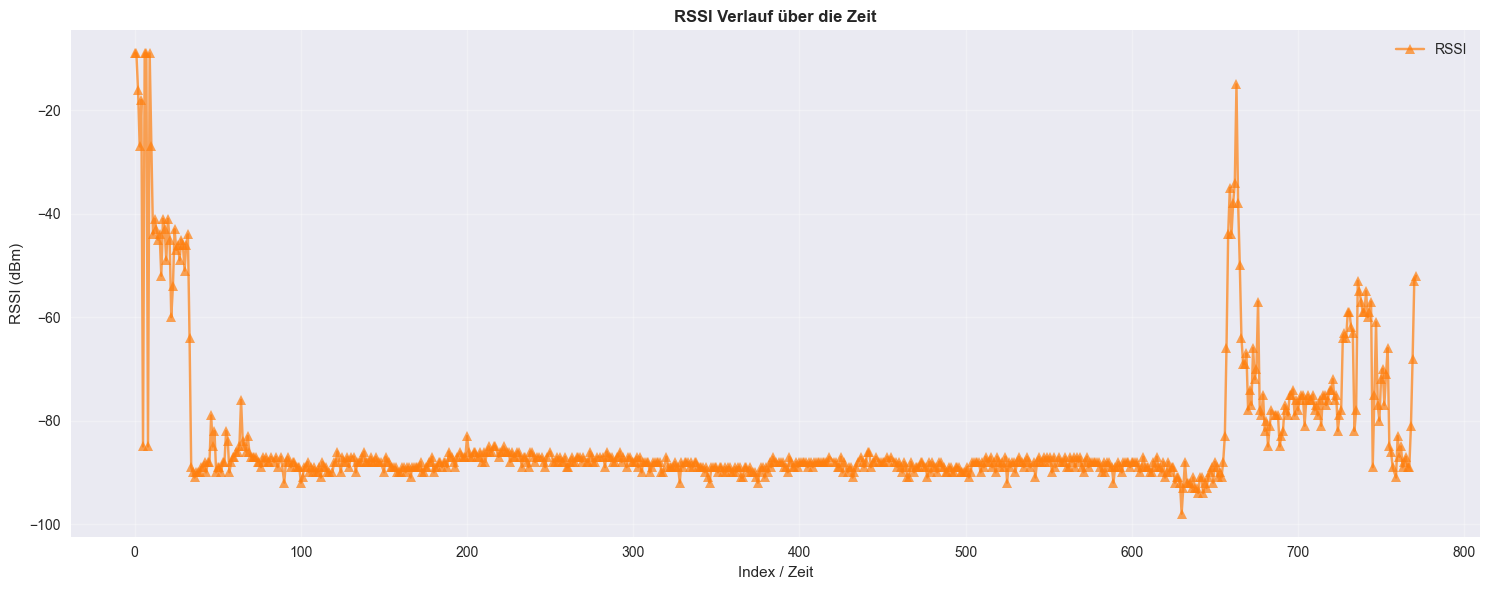

,norm_snr,SNR,RSSI
0,1.533333,13.8,-9
1,1.533333,13.8,-9
2,0.656250,10.5,-16
3,0.451852,12.2,-27
4,0.544444,9.8,-18
5,-0.127059,-10.8,-85
6,1.200000,10.8,-9
7,0.833333,7.5,-9
8,-0.162353,-13.8,-85
9,1.311111,11.8,-9


In [ ]:
from IPython.display import display

# Die Formel zur Berechnung des normierten SNR lautet:
# norm_snr = SNR / |RSSI|
# Dabei wird der SNR-Wert (Signal-to-Noise Ratio) durch den Betrag des RSSI-Werts (Received Signal Strength Indicator) geteilt.
# Ziel ist es, die Signalqualität relativ zur Empfangsstärke darzustellen und so unterschiedliche SFs vergleichbar zu machen.


norm_snr = df_plot['snr_db'] / df.loc[df_plot.index, 'rssi_dbm'].abs()
df_plot['norm_snr'] = norm_snr

sf_order = sorted(df_plot['sf_label'].unique(), key=lambda x: int(x.replace('SF', '')))

# 1. Boxplot für normierten SNR pro SF mit symmetrischer logarithmischer y-Achse
plt.figure(figsize=(15, 6))
ax = sns.boxplot(data=df_plot, x='sf_label', y='norm_snr', palette='viridis', order=sf_order, showmeans=True)
plt.xlabel('Spreading Factor')
plt.ylabel('Normierter SNR (SNR / |RSSI|)')
plt.title('Normierte SNR-Verteilung pro SF (symlog y-Achse)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('symlog', linthresh=0.1)
plt.tight_layout()
plt.show()

# Übersicht: Wichtigste Werte pro Spreading Factor als formatierte Tabelle

print("\nWICHTIGSTE WERTE PRO SPREADING FACTOR")
print("=" * 40)
sf_summary = df_plot.groupby('sf_label').agg(
    Anzahl=('norm_snr', 'count'),
    Mittelwert_norm_SNR=('norm_snr', 'mean'),
    Median_norm_SNR=('norm_snr', 'median'),
    Min_norm_SNR=('norm_snr', 'min'),
    Max_norm_SNR=('norm_snr', 'max'),
    Mittelwert_SNR=('snr_db', 'mean'),
    Median_SNR=('snr_db', 'median'),
    Min_SNR=('snr_db', 'min'),
    Max_SNR=('snr_db', 'max')
)

sf_summary['Mittelwert_RSSI'] = df_plot.groupby('sf_label').apply(lambda x: df.loc[x.index, 'rssi_dbm'].mean())
sf_summary['Median_RSSI'] = df_plot.groupby('sf_label').apply(lambda x: df.loc[x.index, 'rssi_dbm'].median())
sf_summary['Min_RSSI'] = df_plot.groupby('sf_label').apply(lambda x: df.loc[x.index, 'rssi_dbm'].min())
sf_summary['Max_RSSI'] = df_plot.groupby('sf_label').apply(lambda x: df.loc[x.index, 'rssi_dbm'].max())

sf_summary = sf_summary.loc[sf_order]

# Farbige Markierung für alle Spalten
color_cols = sf_summary.columns.tolist()
display(
    sf_summary.round(3).style
        .background_gradient(subset=color_cols, cmap='viridis')
        .format({
            'Mittelwert_norm_SNR': '{:.3f}', 'Median_norm_SNR': '{:.3f}', 'Min_norm_SNR': '{:.3f}', 'Max_norm_SNR': '{:.3f}',
            'Mittelwert_SNR': '{:.2f}', 'Median_SNR': '{:.2f}', 'Min_SNR': '{:.2f}', 'Max_SNR': '{:.2f}',
            'Mittelwert_RSSI': '{:.2f}', 'Median_RSSI': '{:.2f}', 'Min_RSSI': '{:.0f}', 'Max_RSSI': '{:.0f}',
            'Anzahl': '{:d}'
        })
)

# 2. Plot: Normierter SNR über die Zeit
plt.figure(figsize=(15, 6))
plt.plot(df_plot.index, df_plot['norm_snr'], marker='o', linestyle='-', color='tab:blue', alpha=0.7, label='Normierter SNR')
plt.xlabel('Index / Zeit')
plt.ylabel('Normierter SNR (SNR / |RSSI|)')
plt.title('Normierter SNR Verlauf über die Zeit', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Plot: SNR über die Zeit (separat)
plt.figure(figsize=(15, 6))
plt.plot(df_plot.index, df.loc[df_plot.index, 'snr_db'], marker='s', linestyle='-', color='tab:green', alpha=0.7, label='SNR')
plt.xlabel('Index / Zeit')
plt.ylabel('SNR (dB)')
plt.title('SNR Verlauf über die Zeit', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Plot: RSSI über die Zeit (separat)
plt.figure(figsize=(15, 6))
plt.plot(df_plot.index, df.loc[df_plot.index, 'rssi_dbm'], marker='^', linestyle='-', color='tab:orange', alpha=0.7, label='RSSI')
plt.xlabel('Index / Zeit')
plt.ylabel('RSSI (dBm)')
plt.title('RSSI Verlauf über die Zeit', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Tabelle: Zeige die Werte nebeneinander
display_cols = ['norm_snr']
df_table = df_plot[display_cols].copy()
df_table['SNR'] = df.loc[df_plot.index, 'snr_db']
df_table['RSSI'] = df.loc[df_plot.index, 'rssi_dbm']
display(df_table.head(10))